## fakefriends.csv

1. user_id: 사용자ID 
2. name:사용자 이름
3. age: 사용자 나이
4. num_friends: 친구 수 

In [1]:
from pyspark import SparkConf, SparkContext
#스파크 환경 설정 객체 생성
conf = SparkConf().setMaster("local").setAppName("241205_04_RDDEXAM")
spark = SparkContext(conf=conf).getOrCreate()
spark

24/12/06 18:08:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


<SparkContext master=local appName=241205_04_RDDEXAM>

In [2]:
import os
directory = os.path.join(os.getcwd(), "data")
filename = "fakefriends.csv"
filepath = os.path.join(directory, filename)
filepath_spark = "file:///"+filepath.replace("\\","/")
lines = spark.textFile(filepath_spark)

# 경로가 올바른지 확인
print("Current working directory:", os.getcwd())
print("File path:", filepath)
print("Does the file exist?", os.path.exists(filepath))

Current working directory: /home/lab05/src
File path: /home/lab05/src/data/fakefriends.csv
Does the file exist? True


In [3]:
# RDD 생성
rdd = lines.map(lambda x: x.split(','))
rdd.take(5)

[['0', 'Will', '33', '385'],
 ['1', 'Jean-Luc', '26', '2'],
 ['2', 'Hugh', '55', '221'],
 ['3', 'Deanna', '40', '465'],
 ['4', 'Quark', '68', '21']]

In [4]:
#평균 친구수 구하기

# 1. 친구 수 RDD 
rdd_friends = rdd.map(lambda x:int(x[3]))

# 2. 총 친구 수 
total_friends = rdd_friends.reduce(lambda x,y: x+y) #124266

# 3. 전체 이용자 수 
num_friends = rdd_friends.count() #500

# 4. 평균 친구 수
print(f'평균 친구 수: {total_friends/num_friends}') #다들 친구가 많네..? 

평균 친구 수: 248.532


In [5]:
# 가장 친구가 많은/적은 사용자 찾기

#1. user& 친구수 RDD
rdd_user_friends = rdd.map(lambda x: (x[1], int(x[3])))

#2. 가장 많은/적은 친구 수는 몇명인지 
max_friends = rdd_user_friends.map(lambda x: x[1]).max()
min_friends = rdd_user_friends.map(lambda x: x[1]).min()

#3. 그 수와 같은 이름들 필터링
max_users = rdd_user_friends.filter(lambda x: x[1] == max_friends).collect()
min_users = rdd_user_friends.filter(lambda x: x[1] == min_friends).collect()

for (k,v) in max_users:
    print(f'가장 많은, {v} 명의 친구를 가진 사용자는 {k} 입니다!!')
for (k,v) in min_users:
    print(f'가장 적은, {v} 명의 친구를 가진 사용자는 {k} 입니다!!')

가장 많은, 499 명의 친구를 가진 사용자는 Beverly 입니다!!
가장 많은, 499 명의 친구를 가진 사용자는 Data 입니다!!
가장 많은, 499 명의 친구를 가진 사용자는 Julian 입니다!!
가장 적은, 1 명의 친구를 가진 사용자는 Julian 입니다!!
가장 적은, 1 명의 친구를 가진 사용자는 Nog 입니다!!


In [6]:
# 친구 수가 100 이상인 사용자 필터링
filtered_num_friends = rdd_user_friends.filter(lambda x: x[1]>=100)
filtered_num_friends.count() #394명 

# 친구 수가 490 이상인 사용자 필터링 - 100명이상 너무 많아서 490명으로 필터링
filtered_num_friends = rdd_user_friends.filter(lambda x: x[1]>=490)
sorted(filtered_num_friends.collect()) #14명

[('Beverly', 499),
 ('Data', 493),
 ('Data', 499),
 ('Dukat', 496),
 ('Geordi', 493),
 ('Jadzia', 497),
 ('Jean-Luc', 490),
 ('Jean-Luc', 496),
 ('Julian', 499),
 ('Keiko', 491),
 ('Keiko', 492),
 ('Nerys', 492),
 ('Will', 491),
 ('Worf', 492)]

In [7]:
# 특정 나이에 속한 사람들의 친구 수 합계

#1. RDD 연령대별 그룹화
rdd_user_age = rdd.map(lambda x: ((int(x[2]) // 10) * 10, int(x[3]))) # 10대, 20대, 30대,... 
grouping = rdd_user_age.groupByKey()

#연령대별 친구 수 합
sum_friends = grouping.mapValues(lambda x:sum(x)) #or rdd_user_age3.reduceByKey(lambda x, y: x + y)
result_sum = sorted(sum_friends.collect())

min_age_group = min(result_sum, key = lambda x:x[1])
max_age_group = max(result_sum, key = lambda x:x[1])

for (k,v) in result_sum:
    print(f'{k}대: {v} 명')

10대: 5093 명
20대: 21503 명
30대: 22887 명
40대: 26455 명
50대: 24360 명
60대: 23968 명


In [8]:
#데이터 프레임 & 시각화

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(result_sum, columns =['Age', 'Number of friends'])
df

,Age,Number of friends
0,10,5093
1,20,21503
2,30,22887
3,40,26455
4,50,24360
5,60,23968


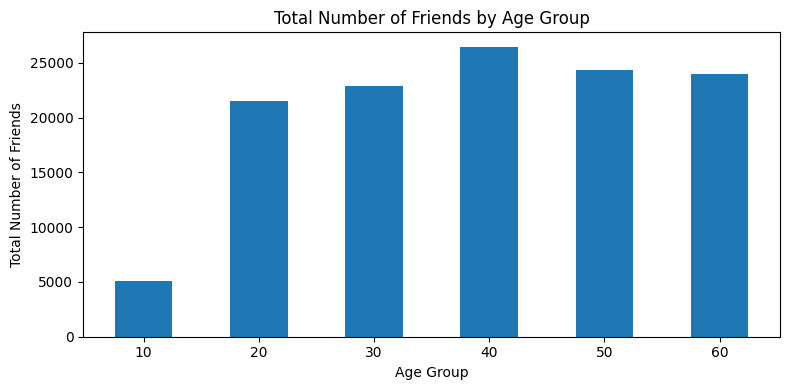

친구 합계가 가장 적은 연령대는 5093 명의 10대 입니다!
친구 합계가 가장 많은 연령대는 26455 명의 40 대 입니다!


In [9]:
plt.figure(figsize=(8,4))
x = df['Age']
y = df['Number of friends']
plt.bar(x,y, width=5)
plt.title("Total Number of Friends by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Total Number of Friends")
plt.tight_layout()
plt.show()

    
print(f'친구 합계가 가장 적은 연령대는 {min_age_group[1]} 명의 {min_age_group[0]}대 입니다!')
print(f'친구 합계가 가장 많은 연령대는 {max_age_group[1]} 명의 {max_age_group[0]} 대 입니다!')

In [10]:
# 분석 주제 추가

#같은 이름, 같은 나이 잃어버린 쌍둥이 찾아주기 :) 

# 1.이름과 나이 유저 페어링
pairs_name_age = rdd.map(lambda x: (x[1],x[2]))
#pairs_name_age.collect()

#2. 카운트 
counts = pairs_name_age.map(lambda x: (x,1))
#counts.collect()

#3. 같은 이름 찾기
same_name_age = counts.reduceByKey(lambda x,y: x+y)
#same_name_age.collect()

# 중복 찾기
find_lost_twins = same_name_age.filter(lambda x: x[1] > 1)
find_lost_twins.collect() 

[(('Hugh', '55'), 2),
 (('Jadzia', '38'), 2),
 (('Ben', '57'), 2),
 (('Keiko', '54'), 4),
 (('Jean-Luc', '56'), 2),
 (('Odo', '35'), 2),
 (('Geordi', '60'), 2),
 (('Quark', '30'), 2),
 (('Keiko', '51'), 2),
 (('Nog', '48'), 2),
 (('Nog', '26'), 2),
 (('Deanna', '64'), 2),
 (('Morn', '25'), 3),
 (('Ezri', '40'), 2),
 (('Keiko', '41'), 2),
 (('Morn', '59'), 2),
 (('Keiko', '69'), 2),
 (('Brunt', '52'), 2),
 (('Dukat', '67'), 2),
 (('Hugh', '57'), 2),
 (('Geordi', '32'), 3),
 (('Ben', '28'), 2),
 (('Ezri', '31'), 2),
 (('Worf', '24'), 2),
 (('Will', '44'), 2),
 (('Dukat', '32'), 2),
 (('Beverly', '18'), 2),
 (('Jean-Luc', '68'), 2),
 (('Deanna', '35'), 2),
 (('Jadzia', '45'), 2),
 (('Brunt', '26'), 2),
 (('Gowron', '67'), 2),
 (('Quark', '19'), 2),
 (('Ben', '45'), 2),
 (('Will', '19'), 2),
 (('Martok', '28'), 2),
 (('Miles', '36'), 2),
 (('Guinan', '59'), 2),
 (('Data', '60'), 2),
 (('Nerys', '39'), 2),
 (('Beverly', '49'), 2),
 (('Ezri', '59'), 2),
 (('Quark', '48'), 2),
 (('Kasidy', '5

In [11]:
# 아이디 중복은 없음! - 동일 인물 없음! 
duplicated_userid = rdd.map(lambda x: (x[0],1))
result = duplicated_userid.reduceByKey(lambda x,y:x+y)
result2 = result.filter(lambda x: x[1] > 1)
result2.collect()

[]

In [12]:
spark.stop()